In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)
dfV4 = dfV4.dropna(subset=['down', 'defteam', 'posteam'])
dfV4 = dfV4.reset_index(drop=True)

# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# Offense needs to score
dfV4['off_need_score'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['first_down'] == 1)
).astype(int)

# Defense Needs a Stop
dfV4['def_need_stop'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['turnover'] == 1)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['off_need_score'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['def_need_stop'] == 1) & ((dfV4['def_td'] == 'def_td')) | dfV4['turnover'] == 1) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop #### Needs fixing, only want 1 on last play of drive when they score or get stop, right now 1 for whole drive
dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 
dfV4['cumulative_drive_time'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()
dfV4['long_drive_triggered'] = (
    dfV4.groupby(['game_id', 'drive'])['cumulative_drive_time']
    .transform(lambda x: (x > 360).idxmax() == x.index)  # Flags the first row that exceeds 360s
).astype(int)

dfV4['quick_score'] = (
    (dfV4['drive_time_seconds'] < 180) &
    ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made')) &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)
dfV4['quick_stop'] = (
    (dfV4['total_drive_time'] < 180) & 
    (dfV4['scoring_type'] == 'none') &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)

# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)


columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')

dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('off_need_score', dfV5['off_need_score'] == 1),
    ('def_need_stop', dfV5['def_need_stop'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] >= 2),
    ('away_csum_scores', dfV5['away_csum_scores'] >= 2),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] >= 2),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] >= 2),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] >= 2),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] >= 2),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]


def_wp_change = {
    "big_defensive_play": 0.029471,
    "def_td": 0.016322,
    "big_st_play": 0.034637,
    "st_return_td": 0.040082,
    "def_need_stop": 0.042132,
    "quick_stop": 0.029971
}

off_wp_change = {
    "big_offensive_play": 0.038602,
    "off_td": 0.028432,
    "off_need_score":  0.035536, 
    "drought_end_play": 0.028891,
    "long_td": 0.033325,
    "quick_score": 0.026664
}

streaks_multipliers = {
    "home_csum_scores": 1.118986,
    "away_csum_scores": 1.118986,
    "home_csum_first_downs": 1.1112094,
    "away_csum_first_downs": 1.1112094,
    "home_csum_def_stops": 1.111932,
    "away_csum_def_stops": 1.111932,
}

score_game_multipliers = {
    "tied_or_1_score": 1.06634844,
    "2_score": 1.035777727,
    "3_or_more_score": 1.0274060
}

qtr_multipliers = {
    "first_and_fourth": 1.5522285,
    "second_and_third": 1.3201836
}

home_away_multipliers = {
    "home": 1.07949869,  
    "away": 1.06027507 
}

boost_case_multipliers = {
    "home_and_4th": 1.122276683,  
    "away_and_1st": 1.16675933,  
    "none": 1.0           
}

decay_multipliers = {
    "opponent_scores": 0.68004571,
    "turnover": 0.21742678,
    "opponent_ends_drought": 0.18212307,
    "long_possession":  0.1534018395,
    "none": 0.0  
}



def calculate_multipliers(row, index, category, is_offensive):
    if abs(row['home_score_differential']) <= 8:
        S = score_game_multipliers["tied_or_1_score"]
    elif 9 <= abs(row['home_score_differential']) <= 16:
        S = score_game_multipliers["2_score"]
    else:
        S = score_game_multipliers["3_or_more_score"]

    team = row['posteam'] if is_offensive else row['defteam']
    HA = home_away_multipliers.get(team, 1.0)

    if row['qtr'] == 1 or row['qtr'] == 4:
        Q = qtr_multipliers["first_and_fourth"]
    else:
        Q = qtr_multipliers["second_and_third"]

    if is_offensive:
        if row['posteam'] == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif row['posteam'] == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0
    else:
        if team == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif team == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0

    CS = 1.0
   
    if is_offensive:
        if row['posteam'] == row['home_team']:
            if row['home_csum_scores'] >= 2:
                if row['home_csum_scores'] > dfV5.at[index - 1, 'home_csum_scores']: 
                    CS = streaks_multipliers['home_csum_scores']
            elif row['home_csum_first_downs'] >= 4:
                if row['home_csum_first_downs'] > dfV5.at[index - 1, 'home_csum_first_downs']: 
                    CS = streaks_multipliers['home_csum_first_downs']
            else:
                CS = 1.0
        else:
            if row['away_csum_scores'] >= 2:
                if row['away_csum_scores'] > dfV5.at[index - 1, 'away_csum_scores']: 
                    CS = streaks_multipliers['away_csum_scores']
            elif row['away_csum_first_downs'] >= 4:
                if row['away_csum_first_downs'] >  dfV5.at[index - 1, 'away_csum_first_downs']: 
                    CS = streaks_multipliers['away_csum_first_downs']
            else:
                CS = 1.0
    else:
        if row['defteam'] == row['home_team']:
            if row['home_csum_def_stops'] >= 2:
                if row['home_csum_def_stops'] > dfV5.at[index - 1, 'home_csum_def_stops']: 
                    CS = streaks_multipliers['home_csum_def_stops']
            else:
                CS = 1.0
        else:
            if row['away_csum_def_stops'] >= 2:
                if row['away_csum_def_stops'] > dfV5.at[index - 1, 'away_csum_def_stops']:
                    CS = streaks_multipliers['away_csum_def_stops']
            else:
                CS = 1.0

    return S, HA, B, CS, Q



def calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q):
    return wp_change_value * (S * HA * CS * B * Q) * 1000



def calculate_decay(row, category, momentum_gain):
    if category in ['off_td', 'long_td', 'def_td', 'st_return_td']:
        D = decay_multipliers['opponent_scores']
    elif row['turnover'] == 1:
        D = decay_multipliers['turnover']
    elif row['drought_end_play'] == 1:
        D = decay_multipliers["opponent_ends_drought"]
    elif row['long_drive_triggered'] == 1:  
        D = decay_multipliers['long_possession']
    else:
        D = decay_multipliers['none']

    return momentum_gain * D



def update_momentum_scores(dfV5):
    dfV5['Home_Momentum_Score'] = 500
    dfV5['Away_Momentum_Score'] = 500

    dfV5['game_id_diff'] = dfV5['game_id'] != dfV5['game_id'].shift(1)

    for index, row in dfV5.iterrows():
        if index == 0:  
            continue

        if row['game_id_diff']:
            dfV5.at[index, 'Home_Momentum_Score'] = 500
            dfV5.at[index, 'Away_Momentum_Score'] = 500
            continue

        home_momentum_gain = 0
        away_momentum_gain = 0

        for category, wp_change_value in off_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, True)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['posteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        for category, wp_change_value in def_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, False)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['defteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 'Home_Momentum_Score'] + home_momentum_gain
        dfV5.at[index, 'Away_Momentum_Score'] = dfV5.at[index - 1, 'Away_Momentum_Score'] + away_momentum_gain

update_momentum_scores(dfV5)

dfV5['Game_Momentum_Diff'] = 0

historical_max_diff_mean = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().mean()
historical_max_diff_std = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().std()

base_threshold = historical_max_diff_mean + 0.8 * historical_max_diff_std #.7

dfV5['Game_Momentum_Diff'] = abs(dfV5['Home_Momentum_Score'] - dfV5['Away_Momentum_Score'])
dfV5['Dynamic_Threshold'] = None
dfV5['Momentum_Holding_Team'] = None

def detect_momentum_shifts(game_data):
    momentum_holding_team = None
    last_shift_home_momentum = game_data.iloc[0]['Home_Momentum_Score']
    last_shift_away_momentum = game_data.iloc[0]['Away_Momentum_Score']
    max_momentum_diff_so_far = 0

    for i in range(1, len(game_data)): 
        if i < 10:  # Ignore shifts for the first 10 plays
            continue
        home_momentum_diff = game_data.iloc[i]['Home_Momentum_Score'] - last_shift_home_momentum
        away_momentum_diff = game_data.iloc[i]['Away_Momentum_Score'] - last_shift_away_momentum        

        current_momentum_diff = abs(game_data.iloc[i]['Home_Momentum_Score'] - game_data.iloc[i]['Away_Momentum_Score'])
        max_momentum_diff_so_far = max(max_momentum_diff_so_far, current_momentum_diff)
        game_threshold = max(base_threshold, 0.8 * max_momentum_diff_so_far) #.7
        game_data.iloc[i, game_data.columns.get_loc('Dynamic_Threshold')] = game_threshold

        home_momentum_shift = False
        away_momentum_shift = False

        if home_momentum_diff >= game_threshold and away_momentum_diff < game_threshold * 0.8: #.5
            home_momentum_shift = True
        elif away_momentum_diff >= game_threshold and home_momentum_diff < game_threshold * 0.8: #.5
            away_momentum_shift = True

        if home_momentum_shift:
            momentum_holding_team = "Home"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']
        elif away_momentum_shift:
            momentum_holding_team = "Away"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']

        game_data.iloc[i, game_data.columns.get_loc('Momentum_Holding_Team')] = momentum_holding_team

    return game_data

dfV5 = dfV5.groupby('game_id', group_keys=False).apply(detect_momentum_shifts)

dfV5['Momentum_Shift_Occurred'] = dfV5.groupby('game_id')['Momentum_Holding_Team'].transform(
    lambda x: x.ne(x.shift()) & x.notna()
)

columns_to_fill = ['home_drive_number', 'away_drive_number', 'home_csum_first_downs', 
                    'away_csum_first_downs', 'Dynamic_Threshold', 'yards_gained']
dfV5[columns_to_fill] = dfV5[columns_to_fill].fillna(0)

features = dfV5.drop(['Momentum_Shift_Occurred'], axis=1)  
numeric_df = dfV5.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

df = dfV5.copy()

excluded_cols = ['game_id', 'Momentum_Shift_Occurred', 'Momentum_Holding_Team']
target_col = 'Momentum_Shift_Occurred'
feature_df = df.drop(columns=excluded_cols, errors='ignore')

numeric_cols = feature_df.select_dtypes(include=['number']).columns
categorical_cols = feature_df.select_dtypes(exclude=['number']).columns
if len(categorical_cols) > 0:
    feature_df = pd.get_dummies(feature_df, columns=categorical_cols, drop_first=True)

unique_games = df['game_id'].unique()
unique_games_sorted = sorted(unique_games)
train_size = int(0.8 * len(unique_games_sorted))
train_games = unique_games_sorted[:train_size]
test_games = unique_games_sorted[train_size:]

feature_df['game_id'] = df['game_id']
train_features = feature_df[feature_df['game_id'].isin(train_games)].drop(columns='game_id')
test_features = feature_df[feature_df['game_id'].isin(test_games)].drop(columns='game_id')
X_train = train_features.values
X_test = test_features.values
y_train = df.loc[df['game_id'].isin(train_games), target_col].astype(int).values
y_test = df.loc[df['game_id'].isin(test_games), target_col].astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\seanz\AppData\Local\Temp\ipykernel_22004\4107407487.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['field_goal_result'].fillna('none', inplace=True)
C:\Users\seanz\AppData\Local\Temp\ipykernel_22004\4107407487.py:521: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '548.7808836884615' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 

In [2]:
from scipy.ndimage import maximum_filter1d

df = dfV5.copy()

excluded_cols = ['game_id', 'Momentum_Shift_Occurred', 'Momentum_Holding_Team']
target_col = 'Momentum_Shift_Occurred'
feature_df = df.drop(columns=excluded_cols, errors='ignore')

numeric_cols = feature_df.select_dtypes(include=['number']).columns
categorical_cols = feature_df.select_dtypes(exclude=['number']).columns
if len(categorical_cols) > 0:
    feature_df = pd.get_dummies(feature_df, columns=categorical_cols, drop_first=True)

unique_games = df['game_id'].unique()
unique_games_sorted = sorted(unique_games)
train_size = int(0.8 * len(unique_games_sorted))
train_games = unique_games_sorted[:train_size]
test_games = unique_games_sorted[train_size:]

feature_df['game_id'] = df['game_id']
train_features = feature_df[feature_df['game_id'].isin(train_games)].drop(columns='game_id')
test_features = feature_df[feature_df['game_id'].isin(test_games)].drop(columns='game_id')
X_train = train_features.values
X_test = test_features.values
y_train = df.loc[df['game_id'].isin(train_games), target_col].astype(int).values
y_test = df.loc[df['game_id'].isin(test_games), target_col].astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(32, 16), alpha=0.001, solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_train_proba = mlp.predict_proba(X_train_scaled)[:, 1]
y_test_proba = mlp.predict_proba(X_test_scaled)[:, 1]

y_train_pred_threshold = (y_train_proba >= 0.16842105263157897).astype(int)
y_test_pred_threshold = (y_test_proba >= 0.16842105263157897).astype(int)

def apply_temporal_correction(preds, actuals, window_size=4):
    corrected_preds = np.zeros_like(preds)
    for i in range(len(preds)):
        start = max(0, i - window_size)
        end = min(len(preds), i + window_size + 1)
        if preds[i] == 1 and np.any(actuals[start:end] == 1):
            corrected_preds[i] = 1 
    return corrected_preds

y_train_pred_corrected = apply_temporal_correction(y_train_pred_threshold, y_train)
y_test_pred_corrected = apply_temporal_correction(y_test_pred_threshold, y_test)

print("\n=== Train Set with Corrected ±4 Play Window ===")
print(classification_report(y_train, y_train_pred_corrected, zero_division=0))

print("\n=== Test Set with Corrected ±4 Play Window ===")
print(classification_report(y_test, y_test_pred_corrected, zero_division=0))


=== Train Set with Corrected ±4 Play Window ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    331300
           1       0.69      0.77      0.73      6975

    accuracy                           0.99    338275
   macro avg       0.84      0.88      0.86    338275
weighted avg       0.99      0.99      0.99    338275


=== Test Set with Corrected ±4 Play Window ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     82061
           1       0.51      0.42      0.46      1726

    accuracy                           0.98     83787
   macro avg       0.75      0.71      0.73     83787
weighted avg       0.98      0.98      0.98     83787



In [3]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import classification_report

best_params = {
    'subsample': 0.6,
    'scale_pos_weight': 7,
    'n_estimators': 300,
    'min_child_weight': 5,
    'max_depth': 12,
    'learning_rate': 0.05,
    'gamma': 0.1,
    'colsample_bytree': 0.9,
    'random_state': 42,
    'n_jobs': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_scaled, y_train)

best_threshold = 0.5
y_train_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

def apply_temporal_correction(preds, actuals, window_size=4):
    corrected_preds = np.zeros_like(preds)
    for i in range(len(preds)):
        start = max(0, i - window_size)
        end = min(len(preds), i + window_size + 1)
        if preds[i] == 1 and np.any(actuals[start:end] == 1):
            corrected_preds[i] = 1
    return corrected_preds

y_train_corrected = apply_temporal_correction(y_train_pred, y_train)
y_test_corrected = apply_temporal_correction(y_test_pred, y_test)

print("\n=== Train Set Performance (Before Temporal Correction) ===")
print(classification_report(y_train, y_train_pred, zero_division=0))

print("\n=== Test Set Performance (Before Temporal Correction) ===")
print(classification_report(y_test, y_test_pred, zero_division=0))

print("\n=== Train Set Performance (After Temporal Correction) ===")
print(classification_report(y_train, y_train_corrected, zero_division=0))

print("\n=== Test Set Performance (After Temporal Correction) ===")
print(classification_report(y_test, y_test_corrected, zero_division=0))

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Train Set Performance (Before Temporal Correction) ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    331300
           1       0.78      1.00      0.88      6975

    accuracy                           0.99    338275
   macro avg       0.89      1.00      0.94    338275
weighted avg       1.00      0.99      0.99    338275


=== Test Set Performance (Before Temporal Correction) ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     82061
           1       0.49      0.52      0.51      1726

    accuracy                           0.98     83787
   macro avg       0.74      0.75      0.75     83787
weighted avg       0.98      0.98      0.98     83787


=== Train Set Performance (After Temporal Correction) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    331300
           1       0.86      1.00      0.93      6975

    

In [4]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

lgbm_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [6, 10, 12],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.9],
    "scale_pos_weight": [5, 7, 10]
}

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, 25],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced"]
}

logreg_param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "class_weight": ["balanced"]
}

lgbm = LGBMClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
logreg = LogisticRegression(max_iter=1000, random_state=42)

lgbm_search = RandomizedSearchCV(lgbm, lgbm_param_grid, n_iter=10, scoring='f1', cv=3, n_jobs=-1, verbose=1)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, scoring='f1', cv=3, n_jobs=-1, verbose=1)
logreg_search = RandomizedSearchCV(logreg, logreg_param_grid, n_iter=10, scoring='f1', cv=3, n_jobs=-1, verbose=1)

lgbm_search.fit(X_train_scaled, y_train)
rf_search.fit(X_train_scaled, y_train)
logreg_search.fit(X_train_scaled, y_train)

best_lgbm = lgbm_search.best_estimator_
best_rf = rf_search.best_estimator_
best_logreg = logreg_search.best_estimator_

print("Best LGBM:", lgbm_search.best_params_)
print("Best RF:", rf_search.best_params_)
print("Best Logistic Regression:", logreg_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 6975, number of negative: 331300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3682
[LightGBM] [Info] Number of data points in the train set: 338275, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020619 -> initscore=-3.860692
[LightGBM] [Info] Start training from score -3.860692
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best LGBM: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25, '

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
import numpy as np

stacked_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', best_rf), ('lgbm', best_lgbm), ('mlp', mlp)],
    final_estimator=best_logreg,
    cv=5,
    n_jobs=-1
)

stacked_model.fit(X_train_scaled, y_train)
y_train_proba = stacked_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = stacked_model.predict_proba(X_test_scaled)[:, 1]

threshold_values = np.linspace(0.1, 0.9, 9)
best_threshold = 0.5
best_f1 = 0

for threshold in threshold_values:
    y_test_pred_threshold = (y_test_proba >= threshold).astype(int)
    f1 = classification_report(y_test, y_test_pred_threshold, output_dict=True)["1"]["f1-score"]
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n=== Best Classification Threshold Found: {best_threshold:.2f} (F1-Score: {best_f1:.4f}) ===")
y_train_pred_threshold = (y_train_proba >= best_threshold).astype(int)
y_test_pred_threshold = (y_test_proba >= best_threshold).astype(int)

def apply_temporal_correction(preds, actuals, window_size=4):
    corrected_preds = np.zeros_like(preds)
    for i in range(len(preds)):
        start = max(0, i - window_size)
        end = min(len(preds), i + window_size + 1)
        if preds[i] == 1 and np.any(actuals[start:end] == 1):
            corrected_preds[i] = 1  
    return corrected_preds

y_train_pred_corrected = apply_temporal_correction(y_train_pred_threshold, y_train)
y_test_pred_corrected = apply_temporal_correction(y_test_pred_threshold, y_test)

print("\n=== Train Set Performance (Before Temporal Correction) ===")
print(classification_report(y_train, y_train_pred_threshold, zero_division=0))

print("\n=== Test Set Performance (Before Temporal Correction) ===")
print(classification_report(y_test, y_test_pred_threshold, zero_division=0))

print("\n=== Train Set Performance (After Temporal Correction) ===")
print(classification_report(y_train, y_train_pred_corrected, zero_division=0))

print("\n=== Test Set Performance (After Temporal Correction) ===")
print(classification_report(y_test, y_test_pred_corrected, zero_division=0))

c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Best Classification Threshold Found: 0.90 (F1-Score: 0.3891) ===

=== Train Set Performance (Before Temporal Correction) ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    331300
           1       0.32      1.00      0.49      6975

    accuracy                           0.96    338275
   macro avg       0.66      0.98      0.73    338275
weighted avg       0.99      0.96      0.97    338275


=== Test Set Performance (Before Temporal Correction) ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     82061
           1       0.25      0.82      0.39      1726

    accuracy                           0.95     83787
   macro avg       0.63      0.89      0.68     83787
weighted avg       0.98      0.95      0.96     83787


=== Train Set Performance (After Temporal Correction) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99

In [15]:
# Combine predictions and actuals
full_corrected_preds = np.concatenate([y_train_corrected, y_test_corrected])
full_actuals = np.concatenate([y_train, y_test])

# Add to main DataFrame
dfV5['predicted_momentum_shift'] = full_corrected_preds
dfV5['actual_momentum_shift'] = full_actuals

# Investigation counters
success_reasons = {
    'off_td': 0,
    'field_goal': 0,
    'quick_score': 0,
    'first_downs': 0
}
failure_reasons = {
    'opponent_def_event': 0,
    'no_event_found': 0
}

successful_shifts = 0
total_shifts = 0

momentum_indexes = np.where(dfV5['predicted_momentum_shift'] == 1)[0]

for idx in momentum_indexes:
    team = dfV5.loc[idx, 'posteam']
    opponent = dfV5.loc[idx, 'defteam']
    game_id = dfV5.loc[idx, 'game_id']
    success = False
    i = idx + 1

    while i < len(dfV5) and dfV5.loc[i, 'game_id'] == game_id:
        row = dfV5.loc[i]

        if row['posteam'] == team:
            if row.get('off_td', 0) == 1:
                success_reasons['off_td'] += 1
                success = True
                break
            elif row.get('scoring_type', '') == 'fg':
                success_reasons['field_goal'] += 1
                success = True
                break
            elif row.get('quick_score', 0) == 1:
                success_reasons['quick_score'] += 1
                success = True
                break
            elif (
                (team == row['home_team'] and row.get('home_csum_first_downs', 0) >= 5) or
                (team == row['away_team'] and row.get('away_csum_first_downs', 0) >= 5)
            ):
                success_reasons['first_downs'] += 1
                success = True
                break
        else:
            if (
                row.get('turnover', 0) == 1 or
                row.get('quick_stop', 0) == 1 or
                row.get('def_td', 0) == 1 or
                (team == row['home_team'] and row.get('away_csum_first_downs', 0) >= 5) or
                (team == row['away_team'] and row.get('home_csum_first_downs', 0) >= 5)
            ):
                failure_reasons['opponent_def_event'] += 1
                break

        i += 1

    if success:
        successful_shifts += 1
    else:
        failure_reasons['no_event_found'] += 1
    total_shifts += 1
    
print(f"\n=== AD HOC VALIDATION RESULTS ===")
print(f"Total Predicted Momentum Shifts: {total_shifts}")
print(f"Successful Shifts: {successful_shifts}")
print(f"Success Rate: {successful_shifts / total_shifts:.2%}\n")

print("== Reasons for Success ==")
for reason, count in success_reasons.items():
    print(f"{reason}: {count}")

print("\n== Reasons for Failure ==")
for reason, count in failure_reasons.items():
    print(f"{reason}: {count}")


=== AD HOC VALIDATION RESULTS ===
Total Predicted Momentum Shifts: 9332
Successful Shifts: 5092
Success Rate: 54.56%

== Reasons for Success ==
off_td: 996
field_goal: 994
quick_score: 0
first_downs: 3102

== Reasons for Failure ==
opponent_def_event: 4017
no_event_found: 4240


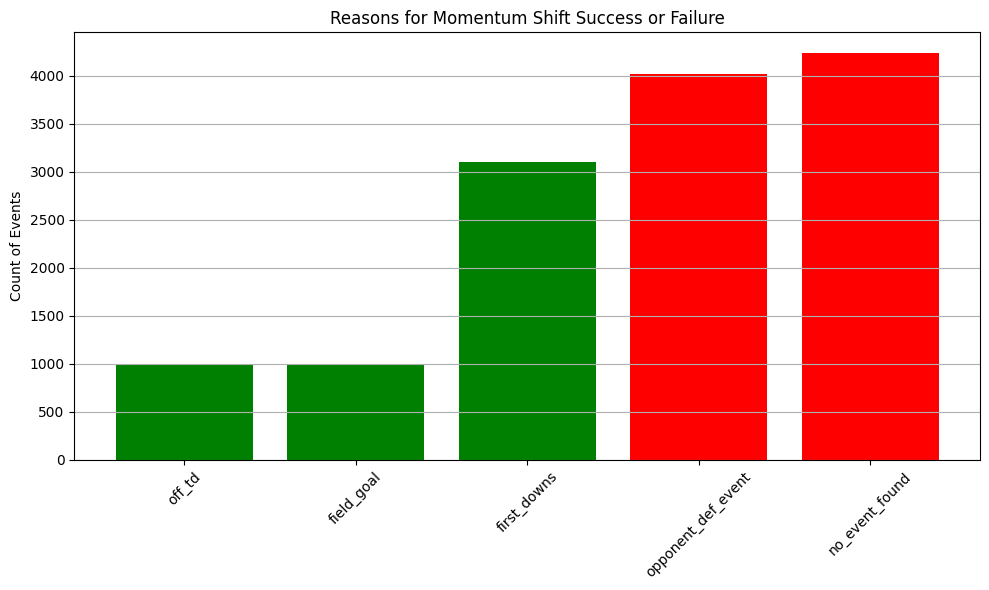

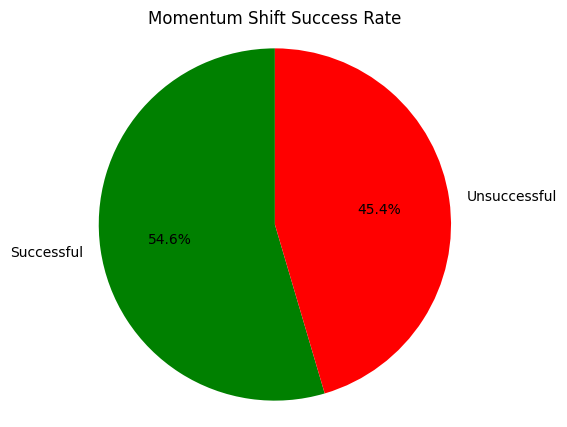

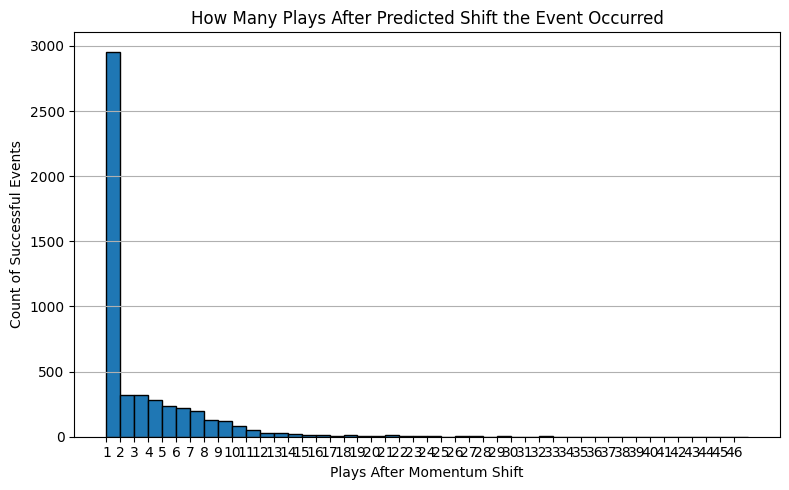

In [18]:
import matplotlib.pyplot as plt

success_reasons = {'off_td': 996, 'field_goal': 994, 'first_downs': 3102}
fail_reasons = {'opponent_def_event': 4017, 'no_event_found': 4240}

# Combine for display
all_reasons = {**success_reasons, **fail_reasons}
colors = ['green' if k in success_reasons else 'red' for k in all_reasons.keys()]

plt.figure(figsize=(10,6))
plt.bar(all_reasons.keys(), all_reasons.values(), color=colors)
plt.title("Reasons for Momentum Shift Success or Failure")
plt.ylabel("Count of Events")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

labels = ['Successful', 'Unsuccessful']
sizes = [5092, 9332 - 5092]
colors = ['green', 'red']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Momentum Shift Success Rate")
plt.axis('equal')
plt.show()

event_offsets = []  # How many plays after shift the success occurred

for idx in momentum_indexes:
    team = dfV5.loc[idx, 'posteam']
    game_id = dfV5.loc[idx, 'game_id']
    opponent = dfV5.loc[idx, 'defteam']

    # Walk forward through the rest of the game
    window_df = dfV5.iloc[idx+1:]
    window_df = window_df[window_df['game_id'] == game_id]

    for offset, (_, row) in enumerate(window_df.iterrows(), start=1):
        if row['posteam'] == team:
            if (
                row.get('off_td', 0) == 1 or
                row.get('scoring_type', '') == 'fg' or
                row.get('quick_score', 0) == 1 or
                (team == row['home_team'] and row.get('home_csum_first_downs', 0) >= 5) or
                (team == row['away_team'] and row.get('away_csum_first_downs', 0) >= 5)
            ):
                event_offsets.append(offset)
                break
        else:
            if (
                row.get('turnover', 0) == 1 or
                row.get('quick_stop', 0) == 1 or
                row.get('def_td', 0) == 1 or
                (team == row['home_team'] and row.get('away_csum_first_downs', 0) >= 5) or
                (team == row['away_team'] and row.get('home_csum_first_downs', 0) >= 5)
            ):
                break  # unsuccessful → don't record
            
plt.figure(figsize=(8, 5))
plt.hist(event_offsets, bins=range(1, max(event_offsets)+2), edgecolor='black')
plt.title("How Many Plays After Predicted Shift the Event Occurred")
plt.xlabel("Plays After Momentum Shift")
plt.ylabel("Count of Successful Events")
plt.xticks(range(1, max(event_offsets)+1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Note:
Logic:
The validation process iterates over predicted momentum shifts and inspects the following plays to determine whether a defined successful event occurs — either:
*If the same team that gained the predicted momentum executes a successful event, it's counted as a successful momentum shift.
*If the opposing team produces a successful event first, the momentum shift is counted as unsuccessful.
*The search stops as soon as an event happens for either team or when the game ends.

Over 50% of the predicted momentum shifts are meaningful and lead to team success in the short term, This is a significant finding, especially considering one of the major criticisms of momentum in sports is that it’s too random or illusory. The results suggest that momentum shifts may have measurable impact and aren’t entirely chance-based

I think these results could even potentially be increased:
-We can see no event found has over half the failures, we could investigate these instances and possibly find more successful events to define in our list of successful events
-Momentum shifts seem to be occurring too late, the visualization shows the majority of the events happen the play after the predicted shift. Tweaking the momentum shift threshold could lead to more events happening after the momentum shift(hopefully the events that could raise the results)

The training at this point takes a pretty long time, and that would need to be where i would try to increase these results, and it could lead to more potential training, so i plan to just focus on these results for now and get a good start on writing